In [1]:
import keras
from keras.layers import Lambda, Input, Dense, Conv2D, Flatten, Conv2DTranspose, Reshape

from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model, to_categorical
from keras import backend as K
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import MinMaxScaler
from gpu import set_gpu

from load_data import load_train_data
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from load_data import process_daq


set_gpu()
tf.compat.v1.disable_eager_execution()

Using TensorFlow backend.
Num GPUs Available:  1


In [2]:
feat,params,daq = load_train_data('train_data_raw_AB.mat')
raw = process_daq(daq,params)
raw = raw[::2,:,:].transpose(2,1,0)
sub = 14
grp = 1
ind = (params[:,0] == sub) & (params[:,3] != grp)

# Shuffle and split data
feat_s, label_s = shuffle(raw[ind,:,:],params[ind,-2,np.newaxis])
x_train, x_test, y_train, y_test = train_test_split(feat_s, label_s, test_size=0.3, random_state=0, stratify=label_s)

scaler = MinMaxScaler(feature_range=(-1,1))
x_train = scaler.fit_transform(x_train.reshape(x_train.shape[0],-1)).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(x_test.shape[0],-1)).reshape(x_test.shape)
x_train = x_train[...,np.newaxis]
x_test = x_test[...,np.newaxis]
y_train = np.squeeze(y_train-1)
y_test = np.squeeze(y_test-1)

In [3]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "digits_over_latent.png")

    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

In [4]:
original_dim = x_train.shape[0] * x_train.shape[1]

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 64
latent_dim = 2
epochs = 30

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=(6,100,1))
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x = Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = Flatten()(x)
x = Dense(16, activation="relu")(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,))
x = Dense(3*50*32, activation="relu")(latent_inputs)
x = Reshape((3, 50, 32))(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=1, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = Conv2DTranspose(1, 3, activation="tanh", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# New: add a classifier
clf_latent_inputs = Input(shape=(latent_dim,), name='z_sampling_clf')
clf_outputs = Dense(7, activation='softmax', name='class_output')(clf_latent_inputs)
clf_supervised = Model(clf_latent_inputs, clf_outputs, name='clf')
clf_supervised.summary()

# instantiate VAE model
outputs = [decoder(encoder(inputs)[2]), clf_supervised(encoder(inputs)[2])]
vae = Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 6, 100, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 3, 50, 32)    320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 3, 50, 32)    9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 4800)         0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [5]:
models = (encoder, decoder)
data = (x_test, y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

reconstruction_loss = tf.reduce_mean(mse(inputs, outputs[0]))

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean((reconstruction_loss + kl_loss)/100.0)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam', loss={'clf': 'categorical_crossentropy'})

vae.fit(x_train, {'clf': y_train},
        epochs=epochs,
        batch_size=batch_size)
vae.save_weights('vae_mlp_mnist.h5')

Epoch 1/30
12250/12250 [==============================] - 4s 315us/step - loss: 14.2385 - clf_loss: 1.7448
Epoch 2/30
12250/12250 [==============================] - 2s 148us/step - loss: 13.1812 - clf_loss: 1.2941
Epoch 3/30
12250/12250 [==============================] - 2s 150us/step - loss: 12.9960 - clf_loss: 1.1019
Epoch 4/30
12250/12250 [==============================] - 2s 148us/step - loss: 12.8463 - clf_loss: 0.9750
Epoch 5/30
12250/12250 [==============================] - 2s 149us/step - loss: 12.7668 - clf_loss: 0.9104
Epoch 6/30
12250/12250 [==============================] - 2s 149us/step - loss: 12.7027 - clf_loss: 0.8559
Epoch 7/30
12250/12250 [==============================] - 2s 149us/step - loss: 12.6497 - clf_loss: 0.8080
Epoch 8/30
12250/12250 [==============================] - 2s 150us/step - loss: 12.5931 - clf_loss: 0.7545
Epoch 9/30
12250/12250 [==============================] - 2s 150us/step - loss: 12.5403 - clf_loss: 0.7036
Epoch 10/30
12250/12250 [============

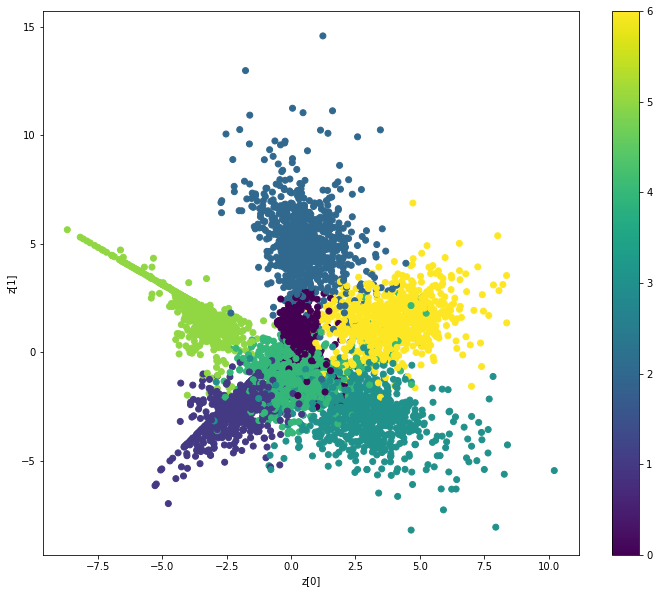

In [6]:
plot_results(models,
                data,
                batch_size=batch_size,
                model_name="vae_mlp")